In [1]:
import os
import getpass
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Qdrant
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_core.prompts import ChatPromptTemplate
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from typing import Annotated, List, Tuple, Union, TypedDict, Optional
from langchain_core.tools import tool
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from qdrant_client import QdrantClient
from langchain_community.tools.tavily_search import TavilySearchResults


In [2]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [3]:

os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

In [4]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE6-Cert_Challenge-rag-agent - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Langsmith API Key: ")

In [5]:
# Initialize LLM and embedding models
llm = ChatOpenAI(model="gpt-4o-mini")
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

In [16]:
response = llm.invoke("Give me details about Radio in Chicago?")
print(response)

content='Chicago has a vibrant radio scene that features a diverse array of genres and formats, including music, talk radio, news, sports, and college broadcasts. Here are some key details about radio in Chicago:\n\n### Major AM and FM Stations\n\n1. **WGN 720 AM**:\n   - A legendary station known for its news, talk shows, and sports broadcasts. It has a long history in Chicago and is one of the oldest radio stations in the U.S.\n\n2. **WGCI 107.5 FM**:\n   - A popular station playing hip-hop and R&B. It has a significant presence in the urban music scene and often features local artists and events.\n\n3. **WXRT 93.1 FM**:\n   - Known for its adult album alternative format, WXRT features a mix of classic rock, indie, and blues music. The station is highly regarded for its live concert broadcasts and music programming.\n\n4. **WBBM Newsradio 780 AM and 105.9 FM**:\n   - A well-respected source for news and traffic updates, WBBM Newsradio offers all-day news coverage, making it a go-to s

In [50]:
# Set up Tavily search tool
tavily_search = TavilySearchResults(max_results=5)

In [7]:
data_folder = 'data'
pdf_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.pdf')]

# Load all PDFs
all_docs = []
for pdf_file in pdf_files:
    loader = PyMuPDFLoader(pdf_file)
    docs = loader.load()
    all_docs.extend(docs)

# Split documents
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
split_docs = splitter.split_documents(all_docs)
print(f'Total split documents: {len(split_docs)}')


Total split documents: 1815


In [8]:
# Set up Qdrant client (local host)
# qdrant_client = QdrantClient(host="localhost", port=6333)
# collection_name = "usa_city_wiki_chunks"
# # Safely delete collection if it exists
# try:
#     qdrant_client.delete_collection(collection_name=collection_name)
# except Exception as e:
#     print(f"Collection deletion error (can be ignored if first run): {e}")

# # Create the collection
# qdrant_client.create_collection(
#     collection_name=collection_name,
#     vectors_config={"size": 1536, "distance": "Cosine"}  # OpenAI embeddings = 1536 dims
# )

# # Set up Qdrant vector store
# vector_store = Qdrant(
#     client=qdrant_client,
#     collection_name=collection_name,
#     embeddings=embedding_model,
# )

# # Add split documents to Qdrant
# vector_store.add_documents(split_docs)
# print("Documents and embeddings stored in Qdrant!")


vector_store = Qdrant.from_documents(
    split_docs,
    embedding_model,
    location=":memory:",
    collection_name="usa_city_wiki_chunks"
)

In [9]:
# Create a retriever from the vector store
retriever = vector_store.as_retriever(search_kwargs={"k": 4})

In [30]:
# Define the RAG prompt template
RAG_PROMPT = """
You are an expert assistant that answers questions using ONLY the provided CONTEXT.
Do NOT make up any information.

CONTEXT:
{context}

USER QUESTION:
{question}

Instructions:
- If the context fully covers the answer, respond concisely and accurately.
- If the context is missing information needed to answer, respond exactly:
  INSUFFICIENT_CONTEXT
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [31]:
# Create the RAG chain
# def format_docs(docs):
#     return "\n\n".join(doc.page_content for doc in docs)

# rag_chain = (
#     {"context": retriever | format_docs, "question": RunnablePassthrough()}
#     | rag_prompt 
#     | llm 
#     | StrOutputParser()
# )

rag_chain =  (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | llm, "context": itemgetter("context")}
)   


In [32]:
rag_chain.invoke({"question": "Give me details about Radio in Chicago?"})["response"].content

"Chicago has five 50,000 watt AM radio stations: WBBM and WSCR, both owned by Audacy; WGN, owned by Tribune Broadcasting; WLS, owned by Cumulus Media; and WMVP, owned by ESPN Radio. Chicago Public Radio produces nationally aired programs such as PRI's This American Life and NPR's Wait Wait...Don't Tell Me!. Additionally, Chicago is home to a number of national radio shows, including Beyond the Beltway with Bruce DuMont, which airs on Sunday evenings."

In [33]:
rag_chain.invoke({"question": "Give me details about San Antonio?"})["response"].content

'INSUFFICIENT_CONTEXT'

In [58]:
# ─────── WRAP rag_chain as a BaseTool ───────
@tool
def rag_tool(input: str) -> dict:
    """Use this tool to answer questions about city information."""
    response = rag_chain.invoke({"question": input})
    return {
        "answer": response["response"],
        "context": response["context"]
    }

In [59]:
result = rag_tool.invoke({"input": "Give me details about San Antonio??"})
print(result)

{'answer': AIMessage(content='INSUFFICIENT_CONTEXT', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 1972, 'total_tokens': 1978, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'finish_reason': 'stop', 'logprobs': None}, id='run-448b42a6-29b7-4ebd-97d9-0619d03ae835-0', usage_metadata={'input_tokens': 1972, 'output_tokens': 6, 'total_tokens': 1978, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), 'context': [Document(metadata={'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-11T02:32:16+00:00', 'source

In [60]:
@tool
def tavily_tool(input: str) -> dict:
    """Use this tool to perform a web search using Tavily and return search results."""
    results = tavily_search.invoke({"query": input})
    return {
        "results": results # this will be a list of dictionaries
    }

In [61]:
result = tavily_tool.invoke({"input": "What is the current temperature in San Antonio"})
print(result)

{'results': [{'url': 'https://www.theweathernetwork.com/en/city/us/texas/san-antonio/current', 'content': 'San Antonio, TX. Updated 4 minutes ago. 23. °C. Overcast. Feels 23. H: 41° L: 24°. Hourly. Full 72 hours · 9am. A mix of sun and clouds. 25°. Feels 25.'}, {'url': 'https://www.timeanddate.com/weather/usa/san-antonio', 'content': 'Weather in San Antonio, Texas, USA\n\nScattered clouds.\n\nFeels Like: 94\xa0°FForecast: 105 / 71\xa0°FWind: 8 mph ↑ from Southeast\n\nLocation: | San Antonio International Airport\nCurrent Time: | May 14, 2025 at 2:01:19 pm\nLatest Report: | May 14, 2025 at 12:51 pm\nVisibility: | 10\xa0mi\nPressure: | 29.67 "Hg\nHumidity: | 52%\nDew Point: | 69\xa0°F\nUpcoming 5 hours\n\nNow | 3:00 pm | 4:00 pm | 5:00 pm | 6:00 pm | 7:00 pm\n |  |  |  |  | \n89\xa0°F | 101\xa0°F | 103\xa0°F | 104\xa0°F | 103\xa0°F | 101\xa0°F\nSee more hour-by-hour weather [...] Wind Direction | S↑ | SE↑ | ESE↑ | SSE↑ | S↑ | SE↑ | SE↑\nHumidity | 30% | 44% | 80% | 72% | 32% | 46% | 82%\

In [63]:
# Define agent state
class AgentState(TypedDict):
    input: str
    rag_result: Optional[dict]
    tavily_result: Optional[dict]

In [72]:
#  Branching function
def should_fallback(state: AgentState) -> str:
    rag_response = state.get("rag_result", {}).get("answer", "")
    # check if rag_response is an AIMessage object
    if hasattr(rag_response, "content"):
        response_text = rag_response.content
    else:
        response_text = rag_response
    
    if response_text.strip().upper() == "INSUFFICIENT_CONTEXT":
        return "fallback"
    else:
        return "continue"


In [74]:
from langchain_core.runnables import RunnableLambda

#Create LangGraph
graph = StateGraph(AgentState)

# Entry point → user provides query
graph.add_node("user_input", RunnableLambda(lambda state: {"input": state["input"]}))
# Call rag_tool
graph.add_node("call_rag", RunnableLambda(lambda state: {"rag_result": rag_tool.invoke({"input": state["input"]})}))

# Check if fallback needed
graph.add_conditional_edges(
    "call_rag",
    should_fallback,
    {
        "continue": END,         # if RAG gave an answer → stop
        "fallback": "call_tavily"  # else → call tavily
    }
)

# Call tavily_tool if needed
graph.add_node("call_tavily", RunnableLambda(lambda state: {
    "tavily_result": tavily_tool.invoke({"input": state["input"]}),
    "rag_result": state["rag_result"]  # keep rag result for context
}))

# Set graph entry + finish
graph.set_entry_point("user_input")
graph.add_edge("user_input", "call_rag")
graph.add_edge("call_tavily", END)

# Compile your runnable agent
agent = graph.compile()


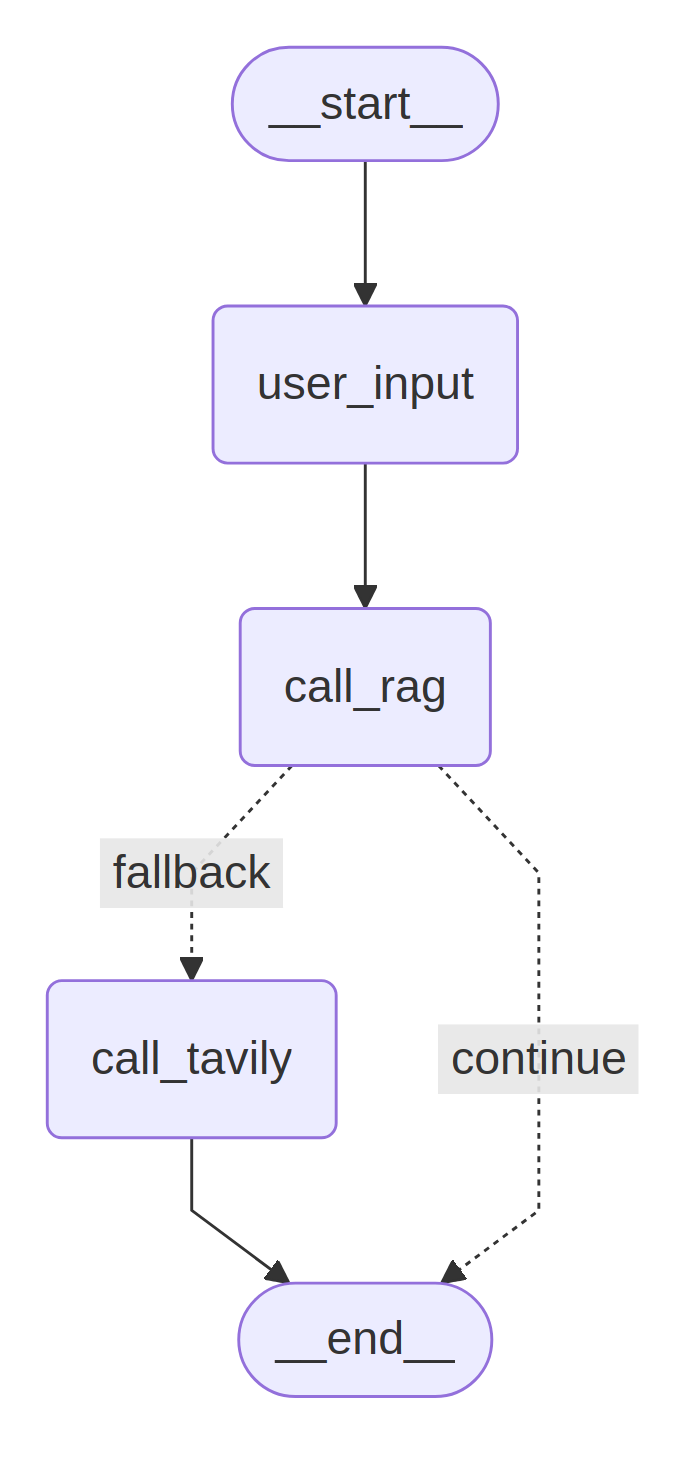

In [75]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

import nest_asyncio
nest_asyncio.apply()

display(
    Image(
        agent.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

In [79]:
user_query = "Tell me the nicknames of Chicago?"

result = agent.invoke({"input": user_query})

# Output result logic
if result.get("tavily_result"):
    print("\n🔎 Answer from Tavily (fallback search):")
    print(result["tavily_result"]["results"])
else:
    print("\n📄 Answer from RAG (your PDFs):")
    print(result["rag_result"]["answer"])
    print("Context used:", result["rag_result"]["context"])


📄 Answer from RAG (your PDFs):
content='The nicknames of Chicago include The Windy City, Chi-Town, Second City, and City of the Big Shoulders.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 1995, 'total_tokens': 2021, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'finish_reason': 'stop', 'logprobs': None} id='run-bf3a0481-5986-4221-bffb-0b3f480e9d94-0' usage_metadata={'input_tokens': 1995, 'output_tokens': 26, 'total_tokens': 2021, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
Context used: [Document(metadata={'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like 

In [81]:
from IPython.display import display, Markdown

# Prepare the input query for testing
inputs = {
    "input": "Give me details about Radio in Chicago??"
}

# Streaming test function for Jupyter
async def test_graph_jupyter():
    async for chunk in agent.astream(inputs, stream_mode="updates"):
        for node, values in chunk.items():
            # 1️⃣ Show node update
            display(Markdown(f"### ✅ Update from node: `{node}`"))

            # 2️⃣ Show rag_tool result if exists
            if "rag_result" in values and values["rag_result"]:
                answer = values["rag_result"].get("answer", "")
                context = values["rag_result"].get("context", "")
                display(Markdown(f"**📄 RAG Answer:**\n```\n{answer}\n```"))
                display(Markdown(f"**📄 RAG Context (preview):**\n```\n{context[:500]}...\n```"))

            # 3️⃣ Show tavily_tool result if exists
            if "tavily_result" in values and values["tavily_result"]:
                display(Markdown(f"**🔎 Tavily Results:**"))
                results = values["tavily_result"].get("results", [])
                for i, item in enumerate(results[:3]):   # limit to 3 results
                    title = item.get("title", "")
                    url = item.get("url", "")
                    content = item.get("content", "")
                    display(Markdown(f"**Result {i+1}:** [{title}]({url})\n\n```\n{content[:300]}...\n```"))

            # 4️⃣ Divider
            display(Markdown("---"))

# 🚀 Run this inside a Jupyter notebook cell
await test_graph_jupyter()


### ✅ Update from node: `user_input`

---

### ✅ Update from node: `call_rag`

**📄 RAG Answer:**
```
content='Chicago has five 50,000 watt AM radio stations: the Audacy-owned WBBM and WSCR; the Tribune Broadcasting-owned WGN; the Cumulus Media-owned WLS; and the ESPN Radio-owned WMVP. Chicago is also home to a number of national radio shows, including "Beyond the Beltway with Bruce DuMont" on Sunday evenings. Chicago Public Radio produces nationally aired programs such as PRI\'s "This American Life" and NPR\'s "Wait Wait...Don\'t Tell Me!".' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 102, 'prompt_tokens': 1665, 'total_tokens': 1767, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'finish_reason': 'stop', 'logprobs': None} id='run-241bc8cc-af1e-4b7d-967c-9ec3f354c456-0' usage_metadata={'input_tokens': 1665, 'output_tokens': 102, 'total_tokens': 1767, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
```

**📄 RAG Context (preview):**
```
[Document(metadata={'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-11T02:32:03+00:00', 'source': 'data/Chicago - Wikipedia.pdf', 'file_path': 'data/Chicago - Wikipedia.pdf', 'total_pages': 57, 'format': 'PDF 1.4', 'title': 'Chicago - Wikipedia', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-05-11T02:32:03+00:00', 'trapped': '', 'page': 27, '_id': '58b625ca1a394293817b1799a3547ed7', '_collection_name': 'usa_city_wiki_chunks'}, page_content="newspaper), the Chicago Reader, the SouthtownStar, the Chicago Defender, the Daily Herald, Newcity,[332][333]\nStreetWise and the Windy City Times. The entertainment and cultural magazine Time Out Chicago and GRAB\nmagazine are also published in the city, as well as local music magazine Chicago Innerview. In addition, Chicago\nis the home of satirical national news outlet, The Onion, as well as its sister pop-culture publication, The A.V.\nClub.[334]\nChicago has five 50,000 watt AM radio stations: the Audacy-owned WBBM and WSCR; the Tribune\nBroadcasting-owned WGN; the Cumulus Media-owned WLS; and the ESPN Radio-owned WMVP. Chicago is also\nhome to a number of national radio shows, including Beyond the Beltway with Bruce DuMont on Sunday\nevenings.\nChicago Public Radio produces nationally aired programs such as PRI's This American Life and NPR's Wait\nWait...Don't Tell Me!.\nTelevision stations\nNewspapers\nMovies and filming\nRadio\n5/10/25, 9:32 PM\nChicago - Wikipedia"), Document(metadata={'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-11T02:32:03+00:00', 'source': 'data/Chicago - Wikipedia.pdf', 'file_path': 'data/Chicago - Wikipedia.pdf', 'total_pages': 57, 'format': 'PDF 1.4', 'title': 'Chicago - Wikipedia', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-05-11T02:32:03+00:00', 'trapped': '', 'page': 27, '_id': 'e076dbc7bc9e49919db2d1220df28ebc', '_collection_name': 'usa_city_wiki_chunks'}, page_content="Wait...Don't Tell Me!.\nTelevision stations\nNewspapers\nMovies and filming\nRadio\n5/10/25, 9:32 PM\nChicago - Wikipedia\nhttps://en.wikipedia.org/wiki/Chicago\n28/57"), Document(metadata={'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-11T02:32:03+00:00', 'source': 'data/Chicago - Wikipedia.pdf', 'file_path': 'data/Chicago - Wikipedia.pdf', 'total_pages': 57, 'format': 'PDF 1.4', 'title': 'Chicago - Wikipedia', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-05-11T02:32:03+00:00', 'trapped': '', 'page': 26, '_id': 'e8fea11223cd414a98c5d1ad7ddf16ce', '_collection_name': 'usa_city_wiki_chunks'}, page_content="Jones Show, and more. The city also has one PBS member station (its\nsecond: WYCC 20, removed its affiliation with PBS in 2017[331]): WTTW\n11, producer of shows such as Sneak Previews, The Frugal Gourmet,\nLamb Chop's Play-Along and The McLaughlin Group. As of 2018, Windy\nCity Live is Chicago's only daytime talk show, which is hosted by Val\nWarner and Ryan Chiaverini at ABC7 Studios with a live weekday\naudience. Since 1999, Judge Mathis also films his syndicated arbitration-\nbased reality court show at the NBC Tower. Beginning in January 2019,\nNewsy began producing 12 of its 14 hours of live news programming per day from its new facility in Chicago.\nMedia\nTelevision\n5/10/25, 9:32 PM\nChicago - Wikipedia\nhttps://en.wikipedia.org/wiki/Chicago\n27/57"), Document(metadata={'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-11T02:32:03+00:00', 'source': 'data/Chicago - Wikipedia.pdf', 'file_path': 'data/Chicago - Wikipedia.pdf', 'total_pages': 57, 'format': 'PDF 1.4', 'title': 'Chicago - Wikipedia', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2025-05-11T02:32:03+00:00', 'trapped': '', 'page': 26, '_id': '4720df9305814d7485a9dce68e31bec2', '_collection_name': 'usa_city_wiki_chunks'}, page_content='The University of Chicago campus as\nseen from the Midway Plaisance\nWGN began in the early days of radio\nand developed into a multi-platform\nbroadcaster, including a cable television\nsuper-station.\nChicago was home of The Oprah Winfrey\nShow from 1986 until 2011, and of other\nHarpo Production operations until 2015.\nChicago State University; the School of the Art Institute of Chicago; East–\nWest University; National Louis University; North Park University;\nNortheastern Illinois University; Robert Morris University Illinois;\nRoosevelt University; Saint Xavier University; Rush University; and\nShimer College.[328]\nWilliam Rainey Harper, the first president of the University of Chicago,\nwas instrumental in the creation of the junior college concept, establishing\nnearby Joliet Junior College as the first in the nation in 1901.[329] His\nlegacy continues with the multiple community colleges in the Chicago\nproper, including the seven City Colleges of Chicago: Richard J. Daley')]...
```

---

RAGAS SGD and LangSmith Evalution

In [ ]:
# Path to the data folder
data_folder = 'data'
pdf_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.pdf')]

# Load all PDFs
all_docs1 = []
for pdf_file in pdf_files:
    loader = PyMuPDFLoader(pdf_file)
    docs1 = loader.load()
    all_docs1.extend(docs1)

In [ ]:
### YOUR CODE HERE
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from ragas.testset import TestsetGenerator

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model="text-embedding-3-small"))
sgd_generator = TestsetGenerator(llm = generator_llm, embedding_model=generator_embeddings)
sgd_dataset = sgd_generator.generate_with_langchain_docs(all_docs1, testset_size=10)

In [ ]:
original_sgd_dataset = sgd_dataset

In [ ]:
sgd_dataset.to_pandas()

In [ ]:
from langsmith import Client

client = Client()

dataset_name = "AIE6 Certification Challenge RAG Evaluation 2"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="AIE6 Certification Challenge RAG Evaluation 2"
)

In [ ]:
for data_row in sgd_dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

In [ ]:
eval_llm = ChatOpenAI(model="gpt-4.1")

In [ ]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)


In [ ]:
def wrapped_react_graph(input_obj):
    question = input_obj["question"]  # ✅ safe extraction
    state = graph.invoke({"messages": [HumanMessage(content=question)]})
    assistant_messages = [m.content for m in state["messages"] if isinstance(m, AIMessage)]
    return {"output": assistant_messages[-1] if assistant_messages else ""}


In [ ]:
evaluate(
    wrapped_react_graph,        # ✅ not react_graph.invoke
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)


Fine Tunning Embeddings

Total split documents: 1477


Generating questions: 100%|██████████| 1181/1181 [30:00<00:00,  1.52s/it] 


Generating questions: 100%|██████████| 148/148 [03:29<00:00,  1.41s/it]


Generating questions: 100%|██████████| 148/148 [03:26<00:00,  1.40s/it]


NameError: name 'training_split_documents' is not defined

In [3]:
8

NameError: name 'train_dataset' is not defined

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
